In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def greedy_compress(g, indice):
    x = g[indice]

    zero_indices = (x == 0)
    nonzero_indices = (x != 0)

    y = x[nonzero_indices]

    power = torch.maximum(-torch.round(torch.log2(torch.abs(y))), torch.zeros_like(y))
    bits = torch.ceil(torch.log2(power + 1))

    y = torch.sign(y) / (2**power)

    x[nonzero_indices] = y

    result = torch.zeros_like(g)
    result[indice] = x

    return result

In [4]:
import torch
from torch.func import functional_call

def mirror_descent(model, X_train, y_train, param_name, impact: torch.Tensor, lr, eta, lambda_value, num_steps, criterion):
    impact = impact.clone().detach().requires_grad_(True)
    original_param = dict(model.named_parameters())[param_name]

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    param_grad = torch.autograd.grad(loss, original_param, create_graph=True)[0]
    new_params = {name: param.clone() for name, param in model.named_parameters()}

    for _ in range(num_steps):
        # Update parameter using impact
        param_new = original_param - lr * (impact / impact.max()) * param_grad
        # Create new parameter dictionary
        new_params[param_name] = param_new
        # Compute outputs with new parameters
        outputs_new = functional_call(model, new_params, (X_train,))
        # Compute new loss
        loss_new = criterion(outputs_new, y_train)

        # Compute gradient of new loss w.r.t. impact
        grad_impact = torch.autograd.grad(loss_new, impact)[0]

        with torch.no_grad():
            impact_update = torch.pow(impact, 1/(1+eta*lambda_value)) * torch.exp(-(eta/(1+eta*lambda_value)) * (grad_impact))
            impact = impact_update / impact_update.sum()

        # Ensure impact requires grad for the next iteration
        impact.requires_grad_(True)

    return impact.detach()

In [5]:
from math import ceil
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

def train(model, optimizer, criterion, train_dataset, val_dataset, num_epochs, compression_type, lr, param_usage=0.2):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    w = {}
    for epoch in trange(num_epochs):
        print('\nEpoch: %d' % epoch)
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        if epoch == 0 and (compression_type == 'mirror_descent_stochastic'\
                           or compression_type == 'mirror_descent_greedy'\
                           or compression_type == 'mirror_descent_greedy_weighted'\
                           or compression_type == 'mirror_descent_greedy_topk'\
                           or compression_type == 'mirror_descent_weighted_topk'):
            w = {name: (imp := torch.rand_like(param)) / imp.sum()
                for name, param in model.named_parameters()
            }
        for batch_idx, (inputs, targets) in enumerate(train_dataset):
            inputs, targets = inputs.to(device), targets.to(device)
            if batch_idx == 0 and (compression_type == 'mirror_descent_stochastic'\
                                   or compression_type == 'mirror_descent_greedy'\
                                   or compression_type == 'mirror_descent_greedy_weighted'\
                                   or compression_type == 'mirror_descent_greedy_topk'\
                                   or compression_type == 'mirror_descent_weighted_topk'):
                for name, param in model.named_parameters():
                    w[name] = mirror_descent(
                        model=model,
                        param_name=name,
                        impact=w[name],
                        lr=lr,
                        eta=2.,
                        lambda_value=0.1,
                        num_steps=200,
                        X_train=inputs,
                        y_train=targets,
                        criterion=criterion
                    )
#                     if 'weight' in name:
#                         plt.hist(w[name].cpu().detach().flatten(), bins=50, label=name)
#                         plt.show()
#                         print(f'{name} min: {w[name].min():.5f}, max: {w[name].max():.5f}, min/max: {w[name].min()/w[name].max():.3f}')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            if compression_type == 'square_stochastic':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'square_greedy':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.argsort(w, descending=True)[:ceil(param_usage * len(w))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'random':
                for param in model.parameters():
                    w = torch.ones_like(param.grad.flatten())
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_stochastic':
                for name, param in model.named_parameters():
                    indice = torch.multinomial(w[name].flatten(), ceil(param_usage * len(w[name].flatten())))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy':
                for name, param in model.named_parameters():
                    indice = torch.argsort(w[name].flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy_weighted':
                for name, param in model.named_parameters():
                    indice = torch.argsort(w[name].flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    
                    weights = torch.zeros_like(w[name])
                    weights.flatten()[indice] = w[name].flatten()[indice]
                    weights *= ceil(param_usage * len(w[name].flatten())) / weights.sum()
                    
                    param.grad *= weights.reshape(param.shape)
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy_topk':
                for name, param in model.named_parameters():
                    indice1 = torch.argsort(param.grad.flatten()**2, descending=True)[:ceil(2 * param_usage * len(param.flatten()))]
                    indice2 = torch.argsort(w[name].flatten()[indice1], descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    g = torch.zeros_like(param.grad.flatten())
                    g[indice1[indice2]] = param.grad.flatten()[indice1[indice2]]
                    param.grad.copy_(greedy_compress(g, indice1[indice2]).reshape(param.shape))
            elif compression_type == 'mirror_descent_weighted_topk':
                for name, param in model.named_parameters():
                    indice = torch.argsort((param.grad.abs() * w[name]).flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    
                    weights = torch.zeros_like(w[name])
                    weights.flatten()[indice] = w[name].flatten()[indice]
                    weights *= ceil(param_usage * len(w[name].flatten())) / weights.sum()
                    
                    param.grad *= weights.reshape(param.shape)
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            else:
                raise ValueError(f"Compression type {compression_type} not supported")
            
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss /= len(train_dataset)
        train_accuracy = 100. * correct / total
        train_log.append(train_loss)
        train_acc_log.append(train_accuracy)
        
        print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)' % (train_loss, train_accuracy, correct, total))
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_dataset:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss /= len(val_dataset)
        val_accuracy = 100. * correct / total
        val_log.append(val_loss)
        val_acc_log.append(val_accuracy)
        
        print('Validation Loss: %.3f | Validation Acc: %.3f%% (%d/%d)' % (val_loss, val_accuracy, correct, total))
    
    return train_log, train_acc_log, val_log, val_acc_log

In [6]:
compression_types = ['mirror_descent_weighted_topk', 'mirror_descent_greedy_weighted', 'mirror_descent_greedy', 'mirror_descent_stochastic', 'random', 'square_greedy']
param_usage = 0.2
num_epochs = 20
lr = 0.001

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for compression_type in compression_types:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[compression_type], train_acc[compression_type], test_log[compression_type], test_acc[compression_type] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.677 | Train Acc: 37.770% (18885/50000)


  5%|▌         | 1/20 [02:39<50:35, 159.76s/it]

Validation Loss: 1.399 | Validation Acc: 48.100% (4810/10000)

Epoch: 1
Train Loss: 1.289 | Train Acc: 53.286% (26643/50000)


 10%|█         | 2/20 [05:18<47:47, 159.30s/it]

Validation Loss: 1.353 | Validation Acc: 52.050% (5205/10000)

Epoch: 2
Train Loss: 1.099 | Train Acc: 60.524% (30262/50000)


 15%|█▌        | 3/20 [08:02<45:39, 161.17s/it]

Validation Loss: 1.054 | Validation Acc: 62.350% (6235/10000)

Epoch: 3
Train Loss: 0.964 | Train Acc: 65.546% (32773/50000)


 20%|██        | 4/20 [10:39<42:37, 159.86s/it]

Validation Loss: 0.917 | Validation Acc: 67.620% (6762/10000)

Epoch: 4
Train Loss: 0.860 | Train Acc: 69.470% (34735/50000)


 25%|██▌       | 5/20 [13:22<40:14, 160.94s/it]

Validation Loss: 0.883 | Validation Acc: 69.360% (6936/10000)

Epoch: 5
Train Loss: 0.783 | Train Acc: 72.354% (36177/50000)


 30%|███       | 6/20 [16:02<37:28, 160.63s/it]

Validation Loss: 0.823 | Validation Acc: 72.290% (7229/10000)

Epoch: 6
Train Loss: 0.720 | Train Acc: 74.698% (37349/50000)


 35%|███▌      | 7/20 [18:42<34:42, 160.19s/it]

Validation Loss: 0.737 | Validation Acc: 74.220% (7422/10000)

Epoch: 7
Train Loss: 0.655 | Train Acc: 77.032% (38516/50000)


 40%|████      | 8/20 [21:22<32:03, 160.28s/it]

Validation Loss: 0.833 | Validation Acc: 72.090% (7209/10000)

Epoch: 8
Train Loss: 0.618 | Train Acc: 78.418% (39209/50000)


 45%|████▌     | 9/20 [24:04<29:29, 160.89s/it]

Validation Loss: 0.679 | Validation Acc: 76.210% (7621/10000)

Epoch: 9
Train Loss: 0.574 | Train Acc: 80.058% (40029/50000)


 50%|█████     | 10/20 [26:45<26:47, 160.72s/it]

Validation Loss: 0.777 | Validation Acc: 74.140% (7414/10000)

Epoch: 10
Train Loss: 0.540 | Train Acc: 81.260% (40630/50000)


 55%|█████▌    | 11/20 [29:27<24:10, 161.13s/it]

Validation Loss: 0.620 | Validation Acc: 78.760% (7876/10000)

Epoch: 11
Train Loss: 0.514 | Train Acc: 82.006% (41003/50000)


 60%|██████    | 12/20 [32:02<21:15, 159.42s/it]

Validation Loss: 0.613 | Validation Acc: 79.690% (7969/10000)

Epoch: 12
Train Loss: 0.484 | Train Acc: 83.244% (41622/50000)


 65%|██████▌   | 13/20 [34:40<18:32, 158.95s/it]

Validation Loss: 0.549 | Validation Acc: 81.400% (8140/10000)

Epoch: 13
Train Loss: 0.461 | Train Acc: 83.958% (41979/50000)


 70%|███████   | 14/20 [37:16<15:48, 158.07s/it]

Validation Loss: 0.532 | Validation Acc: 82.210% (8221/10000)

Epoch: 14
Train Loss: 0.435 | Train Acc: 84.884% (42442/50000)


 75%|███████▌  | 15/20 [39:54<13:09, 157.97s/it]

Validation Loss: 0.566 | Validation Acc: 81.090% (8109/10000)

Epoch: 15
Train Loss: 0.421 | Train Acc: 85.278% (42639/50000)


 80%|████████  | 16/20 [42:33<10:32, 158.18s/it]

Validation Loss: 0.516 | Validation Acc: 82.860% (8286/10000)

Epoch: 16
Train Loss: 0.401 | Train Acc: 86.060% (43030/50000)


 85%|████████▌ | 17/20 [45:09<07:52, 157.66s/it]

Validation Loss: 0.481 | Validation Acc: 83.530% (8353/10000)

Epoch: 17
Train Loss: 0.384 | Train Acc: 86.714% (43357/50000)


 90%|█████████ | 18/20 [47:50<05:17, 158.73s/it]

Validation Loss: 0.517 | Validation Acc: 82.710% (8271/10000)

Epoch: 18
Train Loss: 0.368 | Train Acc: 87.214% (43607/50000)


 95%|█████████▌| 19/20 [50:32<02:39, 159.57s/it]

Validation Loss: 0.506 | Validation Acc: 83.390% (8339/10000)

Epoch: 19
Train Loss: 0.351 | Train Acc: 87.830% (43915/50000)


100%|██████████| 20/20 [53:12<00:00, 159.63s/it]


Validation Loss: 0.487 | Validation Acc: 83.710% (8371/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.894 | Train Acc: 29.698% (14849/50000)


  5%|▌         | 1/20 [02:39<50:39, 159.98s/it]

Validation Loss: 1.656 | Validation Acc: 38.450% (3845/10000)

Epoch: 1
Train Loss: 1.555 | Train Acc: 42.630% (21315/50000)


 10%|█         | 2/20 [05:18<47:44, 159.13s/it]

Validation Loss: 1.430 | Validation Acc: 46.610% (4661/10000)

Epoch: 2
Train Loss: 1.254 | Train Acc: 54.476% (27238/50000)


 20%|██        | 4/20 [10:35<42:20, 158.76s/it]

Validation Loss: 1.201 | Validation Acc: 56.400% (5640/10000)

Epoch: 4
Train Loss: 1.161 | Train Acc: 58.092% (29046/50000)


 25%|██▌       | 5/20 [13:14<39:45, 159.04s/it]

Validation Loss: 1.094 | Validation Acc: 61.140% (6114/10000)

Epoch: 5
Train Loss: 1.075 | Train Acc: 61.226% (30613/50000)


 30%|███       | 6/20 [15:51<36:56, 158.32s/it]

Validation Loss: 1.061 | Validation Acc: 61.790% (6179/10000)

Epoch: 6
Train Loss: 1.006 | Train Acc: 63.970% (31985/50000)


 35%|███▌      | 7/20 [18:29<34:14, 158.06s/it]

Validation Loss: 1.034 | Validation Acc: 63.260% (6326/10000)

Epoch: 7
Train Loss: 0.957 | Train Acc: 65.852% (32926/50000)


 40%|████      | 8/20 [21:05<31:30, 157.52s/it]

Validation Loss: 1.013 | Validation Acc: 64.680% (6468/10000)

Epoch: 8
Train Loss: 0.908 | Train Acc: 67.786% (33893/50000)


 45%|████▌     | 9/20 [23:42<28:49, 157.27s/it]

Validation Loss: 0.925 | Validation Acc: 67.480% (6748/10000)

Epoch: 9
Train Loss: 0.866 | Train Acc: 69.254% (34627/50000)


 50%|█████     | 10/20 [26:19<26:12, 157.22s/it]

Validation Loss: 0.900 | Validation Acc: 68.170% (6817/10000)

Epoch: 10
Train Loss: 0.830 | Train Acc: 70.524% (35262/50000)


 55%|█████▌    | 11/20 [28:52<23:24, 156.11s/it]

Validation Loss: 0.849 | Validation Acc: 70.630% (7063/10000)

Epoch: 11
Train Loss: 0.794 | Train Acc: 71.974% (35987/50000)


 60%|██████    | 12/20 [31:33<20:59, 157.48s/it]

Validation Loss: 0.855 | Validation Acc: 69.940% (6994/10000)

Epoch: 12
Train Loss: 0.757 | Train Acc: 73.194% (36597/50000)


 65%|██████▌   | 13/20 [34:09<18:18, 156.97s/it]

Validation Loss: 0.787 | Validation Acc: 72.140% (7214/10000)

Epoch: 13
Train Loss: 0.727 | Train Acc: 74.216% (37108/50000)


 70%|███████   | 14/20 [36:46<15:42, 157.12s/it]

Validation Loss: 0.730 | Validation Acc: 74.590% (7459/10000)

Epoch: 14
Train Loss: 0.703 | Train Acc: 75.250% (37625/50000)


 75%|███████▌  | 15/20 [39:26<13:10, 158.00s/it]

Validation Loss: 0.757 | Validation Acc: 74.230% (7423/10000)

Epoch: 15
Train Loss: 0.669 | Train Acc: 76.342% (38171/50000)


 80%|████████  | 16/20 [42:08<10:36, 159.05s/it]

Validation Loss: 0.711 | Validation Acc: 75.250% (7525/10000)

Epoch: 16
Train Loss: 0.650 | Train Acc: 77.246% (38623/50000)


 85%|████████▌ | 17/20 [44:48<07:58, 159.53s/it]

Validation Loss: 0.718 | Validation Acc: 75.410% (7541/10000)

Epoch: 17
Train Loss: 0.622 | Train Acc: 78.154% (39077/50000)


 90%|█████████ | 18/20 [47:31<05:20, 160.40s/it]

Validation Loss: 0.747 | Validation Acc: 74.960% (7496/10000)

Epoch: 18
Train Loss: 0.599 | Train Acc: 78.934% (39467/50000)


 95%|█████████▌| 19/20 [50:17<02:42, 162.20s/it]

Validation Loss: 0.677 | Validation Acc: 76.970% (7697/10000)

Epoch: 19
Train Loss: 0.580 | Train Acc: 79.818% (39909/50000)


100%|██████████| 20/20 [52:59<00:00, 159.00s/it]


Validation Loss: 0.654 | Validation Acc: 77.720% (7772/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.879 | Train Acc: 30.328% (15164/50000)


  5%|▌         | 1/20 [02:34<48:57, 154.61s/it]

Validation Loss: 1.632 | Validation Acc: 38.900% (3890/10000)

Epoch: 1
Train Loss: 1.556 | Train Acc: 42.452% (21226/50000)


 10%|█         | 2/20 [05:13<47:09, 157.18s/it]

Validation Loss: 1.462 | Validation Acc: 46.910% (4691/10000)

Epoch: 2
Train Loss: 1.392 | Train Acc: 49.274% (24637/50000)


 15%|█▌        | 3/20 [07:54<44:57, 158.68s/it]

Validation Loss: 1.298 | Validation Acc: 53.480% (5348/10000)

Epoch: 3
Train Loss: 1.265 | Train Acc: 54.250% (27125/50000)


 20%|██        | 4/20 [10:27<41:48, 156.76s/it]

Validation Loss: 1.224 | Validation Acc: 56.510% (5651/10000)

Epoch: 4
Train Loss: 1.165 | Train Acc: 58.098% (29049/50000)


 25%|██▌       | 5/20 [13:06<39:21, 157.40s/it]

Validation Loss: 1.205 | Validation Acc: 56.920% (5692/10000)

Epoch: 5
Train Loss: 1.091 | Train Acc: 61.048% (30524/50000)


 30%|███       | 6/20 [15:48<37:05, 158.99s/it]

Validation Loss: 1.086 | Validation Acc: 60.970% (6097/10000)

Epoch: 6
Train Loss: 1.017 | Train Acc: 63.714% (31857/50000)


 35%|███▌      | 7/20 [18:26<34:24, 158.80s/it]

Validation Loss: 1.121 | Validation Acc: 61.050% (6105/10000)

Epoch: 7
Train Loss: 0.966 | Train Acc: 65.522% (32761/50000)


 40%|████      | 8/20 [21:04<31:40, 158.34s/it]

Validation Loss: 1.008 | Validation Acc: 64.390% (6439/10000)

Epoch: 8
Train Loss: 0.906 | Train Acc: 67.882% (33941/50000)


 45%|████▌     | 9/20 [23:42<29:01, 158.28s/it]

Validation Loss: 0.898 | Validation Acc: 68.530% (6853/10000)

Epoch: 9
Train Loss: 0.864 | Train Acc: 69.324% (34662/50000)


 50%|█████     | 10/20 [26:20<26:21, 158.11s/it]

Validation Loss: 0.894 | Validation Acc: 68.480% (6848/10000)

Epoch: 10
Train Loss: 0.817 | Train Acc: 71.190% (35595/50000)


 55%|█████▌    | 11/20 [29:02<23:53, 159.27s/it]

Validation Loss: 0.830 | Validation Acc: 70.760% (7076/10000)

Epoch: 11
Train Loss: 0.785 | Train Acc: 72.218% (36109/50000)


 60%|██████    | 12/20 [31:28<20:43, 155.42s/it]

Validation Loss: 0.820 | Validation Acc: 71.680% (7168/10000)

Epoch: 12
Train Loss: 0.748 | Train Acc: 73.568% (36784/50000)


 65%|██████▌   | 13/20 [33:59<17:57, 153.96s/it]

Validation Loss: 0.777 | Validation Acc: 72.880% (7288/10000)

Epoch: 13
Train Loss: 0.717 | Train Acc: 74.746% (37373/50000)


 70%|███████   | 14/20 [36:34<15:25, 154.26s/it]

Validation Loss: 0.741 | Validation Acc: 74.720% (7472/10000)

Epoch: 14
Train Loss: 0.687 | Train Acc: 75.972% (37986/50000)


 75%|███████▌  | 15/20 [39:07<12:49, 154.00s/it]

Validation Loss: 0.769 | Validation Acc: 73.500% (7350/10000)

Epoch: 15
Train Loss: 0.668 | Train Acc: 76.542% (38271/50000)


 80%|████████  | 16/20 [41:40<10:14, 153.59s/it]

Validation Loss: 0.732 | Validation Acc: 74.650% (7465/10000)

Epoch: 16
Train Loss: 0.635 | Train Acc: 77.682% (38841/50000)


 85%|████████▌ | 17/20 [44:12<07:39, 153.25s/it]

Validation Loss: 0.702 | Validation Acc: 76.100% (7610/10000)

Epoch: 17
Train Loss: 0.611 | Train Acc: 78.682% (39341/50000)


 90%|█████████ | 18/20 [46:51<05:09, 154.78s/it]

Validation Loss: 0.653 | Validation Acc: 77.290% (7729/10000)

Epoch: 18
Train Loss: 0.595 | Train Acc: 79.200% (39600/50000)


 95%|█████████▌| 19/20 [49:31<02:36, 156.43s/it]

Validation Loss: 0.698 | Validation Acc: 76.230% (7623/10000)

Epoch: 19
Train Loss: 0.578 | Train Acc: 79.868% (39934/50000)


100%|██████████| 20/20 [52:04<00:00, 156.24s/it]


Validation Loss: 0.601 | Validation Acc: 79.370% (7937/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.883 | Train Acc: 30.990% (15495/50000)


  5%|▌         | 1/20 [02:39<50:26, 159.31s/it]

Validation Loss: 1.629 | Validation Acc: 39.530% (3953/10000)

Epoch: 1
Train Loss: 1.561 | Train Acc: 42.282% (21141/50000)


 10%|█         | 2/20 [05:15<47:12, 157.36s/it]

Validation Loss: 1.463 | Validation Acc: 45.820% (4582/10000)

Epoch: 2
Train Loss: 1.410 | Train Acc: 48.080% (24040/50000)


 15%|█▌        | 3/20 [07:55<44:55, 158.54s/it]

Validation Loss: 1.360 | Validation Acc: 50.590% (5059/10000)

Epoch: 3
Train Loss: 1.289 | Train Acc: 52.936% (26468/50000)


 20%|██        | 4/20 [10:37<42:40, 160.03s/it]

Validation Loss: 1.218 | Validation Acc: 55.790% (5579/10000)

Epoch: 4
Train Loss: 1.195 | Train Acc: 56.806% (28403/50000)


 25%|██▌       | 5/20 [13:29<41:07, 164.50s/it]

Validation Loss: 1.151 | Validation Acc: 58.870% (5887/10000)

Epoch: 5
Train Loss: 1.117 | Train Acc: 59.730% (29865/50000)


 30%|███       | 6/20 [16:11<38:06, 163.34s/it]

Validation Loss: 1.084 | Validation Acc: 61.270% (6127/10000)

Epoch: 6
Train Loss: 1.048 | Train Acc: 62.462% (31231/50000)


 35%|███▌      | 7/20 [18:55<35:27, 163.65s/it]

Validation Loss: 1.010 | Validation Acc: 63.720% (6372/10000)

Epoch: 7
Train Loss: 0.985 | Train Acc: 64.598% (32299/50000)


 40%|████      | 8/20 [21:43<33:00, 165.03s/it]

Validation Loss: 0.961 | Validation Acc: 65.200% (6520/10000)

Epoch: 8
Train Loss: 0.934 | Train Acc: 66.528% (33264/50000)


 45%|████▌     | 9/20 [24:24<30:02, 163.83s/it]

Validation Loss: 0.933 | Validation Acc: 67.050% (6705/10000)

Epoch: 9
Train Loss: 0.894 | Train Acc: 68.084% (34042/50000)


 50%|█████     | 10/20 [27:04<27:05, 162.57s/it]

Validation Loss: 0.901 | Validation Acc: 68.220% (6822/10000)

Epoch: 10
Train Loss: 0.852 | Train Acc: 69.564% (34782/50000)


 55%|█████▌    | 11/20 [29:44<24:15, 161.76s/it]

Validation Loss: 0.853 | Validation Acc: 69.830% (6983/10000)

Epoch: 11
Train Loss: 0.813 | Train Acc: 71.068% (35534/50000)


 60%|██████    | 12/20 [32:28<21:40, 162.53s/it]

Validation Loss: 0.826 | Validation Acc: 70.600% (7060/10000)

Epoch: 12
Train Loss: 0.783 | Train Acc: 72.234% (36117/50000)


 65%|██████▌   | 13/20 [35:13<19:03, 163.34s/it]

Validation Loss: 0.800 | Validation Acc: 72.200% (7220/10000)

Epoch: 13
Train Loss: 0.750 | Train Acc: 73.440% (36720/50000)


 70%|███████   | 14/20 [38:40<17:39, 176.60s/it]

Validation Loss: 0.838 | Validation Acc: 71.130% (7113/10000)

Epoch: 14
Train Loss: 0.726 | Train Acc: 74.424% (37212/50000)


 75%|███████▌  | 15/20 [41:26<14:25, 173.16s/it]

Validation Loss: 0.747 | Validation Acc: 74.000% (7400/10000)

Epoch: 15
Train Loss: 0.697 | Train Acc: 75.472% (37736/50000)


 80%|████████  | 16/20 [44:08<11:19, 169.96s/it]

Validation Loss: 0.739 | Validation Acc: 74.390% (7439/10000)

Epoch: 16
Train Loss: 0.673 | Train Acc: 76.362% (38181/50000)


 85%|████████▌ | 17/20 [46:48<08:21, 167.02s/it]

Validation Loss: 0.737 | Validation Acc: 74.590% (7459/10000)

Epoch: 17
Train Loss: 0.646 | Train Acc: 77.334% (38667/50000)


 90%|█████████ | 18/20 [49:27<05:29, 164.56s/it]

Validation Loss: 0.669 | Validation Acc: 76.470% (7647/10000)

Epoch: 18
Train Loss: 0.622 | Train Acc: 78.380% (39190/50000)


 95%|█████████▌| 19/20 [52:19<02:46, 166.82s/it]

Validation Loss: 0.671 | Validation Acc: 76.480% (7648/10000)

Epoch: 19
Train Loss: 0.605 | Train Acc: 78.774% (39387/50000)


100%|██████████| 20/20 [55:00<00:00, 165.02s/it]


Validation Loss: 0.642 | Validation Acc: 77.750% (7775/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.910 | Train Acc: 29.678% (14839/50000)


  5%|▌         | 1/20 [00:21<06:50, 21.59s/it]

Validation Loss: 1.629 | Validation Acc: 39.630% (3963/10000)

Epoch: 1
Train Loss: 1.583 | Train Acc: 40.978% (20489/50000)


 10%|█         | 2/20 [00:42<06:20, 21.12s/it]

Validation Loss: 1.464 | Validation Acc: 45.530% (4553/10000)

Epoch: 2
Train Loss: 1.435 | Train Acc: 46.880% (23440/50000)


 15%|█▌        | 3/20 [01:03<06:00, 21.20s/it]

Validation Loss: 1.320 | Validation Acc: 51.290% (5129/10000)

Epoch: 3
Train Loss: 1.316 | Train Acc: 52.204% (26102/50000)


 20%|██        | 4/20 [01:24<05:34, 20.91s/it]

Validation Loss: 1.283 | Validation Acc: 53.550% (5355/10000)

Epoch: 4
Train Loss: 1.209 | Train Acc: 56.128% (28064/50000)


 25%|██▌       | 5/20 [01:45<05:17, 21.13s/it]

Validation Loss: 1.160 | Validation Acc: 57.840% (5784/10000)

Epoch: 5
Train Loss: 1.134 | Train Acc: 59.142% (29571/50000)


 30%|███       | 6/20 [02:08<05:03, 21.66s/it]

Validation Loss: 1.114 | Validation Acc: 60.090% (6009/10000)

Epoch: 6
Train Loss: 1.068 | Train Acc: 61.750% (30875/50000)


 35%|███▌      | 7/20 [02:39<05:21, 24.73s/it]

Validation Loss: 1.072 | Validation Acc: 62.090% (6209/10000)

Epoch: 7
Train Loss: 1.009 | Train Acc: 63.864% (31932/50000)


 40%|████      | 8/20 [02:59<04:38, 23.22s/it]

Validation Loss: 0.998 | Validation Acc: 64.830% (6483/10000)

Epoch: 8
Train Loss: 0.963 | Train Acc: 65.588% (32794/50000)


 45%|████▌     | 9/20 [03:22<04:14, 23.09s/it]

Validation Loss: 0.977 | Validation Acc: 65.460% (6546/10000)

Epoch: 9
Train Loss: 0.920 | Train Acc: 67.212% (33606/50000)


 50%|█████     | 10/20 [03:45<03:51, 23.11s/it]

Validation Loss: 0.947 | Validation Acc: 66.800% (6680/10000)

Epoch: 10
Train Loss: 0.879 | Train Acc: 68.608% (34304/50000)


 55%|█████▌    | 11/20 [04:11<03:35, 24.00s/it]

Validation Loss: 0.919 | Validation Acc: 67.590% (6759/10000)

Epoch: 11
Train Loss: 0.845 | Train Acc: 69.934% (34967/50000)


 60%|██████    | 12/20 [04:32<03:05, 23.18s/it]

Validation Loss: 0.882 | Validation Acc: 69.040% (6904/10000)

Epoch: 12
Train Loss: 0.812 | Train Acc: 71.196% (35598/50000)


 65%|██████▌   | 13/20 [05:01<02:53, 24.75s/it]

Validation Loss: 0.826 | Validation Acc: 70.930% (7093/10000)

Epoch: 13
Train Loss: 0.781 | Train Acc: 72.278% (36139/50000)


 70%|███████   | 14/20 [05:30<02:37, 26.19s/it]

Validation Loss: 0.812 | Validation Acc: 71.550% (7155/10000)

Epoch: 14
Train Loss: 0.754 | Train Acc: 73.204% (36602/50000)


 75%|███████▌  | 15/20 [06:00<02:16, 27.38s/it]

Validation Loss: 0.766 | Validation Acc: 72.850% (7285/10000)

Epoch: 15
Train Loss: 0.720 | Train Acc: 74.476% (37238/50000)


 80%|████████  | 16/20 [06:21<01:42, 25.53s/it]

Validation Loss: 0.760 | Validation Acc: 73.180% (7318/10000)

Epoch: 16
Train Loss: 0.694 | Train Acc: 75.502% (37751/50000)


 85%|████████▌ | 17/20 [06:45<01:14, 24.82s/it]

Validation Loss: 0.755 | Validation Acc: 73.690% (7369/10000)

Epoch: 17
Train Loss: 0.671 | Train Acc: 76.184% (38092/50000)


 90%|█████████ | 18/20 [07:05<00:47, 23.56s/it]

Validation Loss: 0.703 | Validation Acc: 75.100% (7510/10000)

Epoch: 18
Train Loss: 0.641 | Train Acc: 77.358% (38679/50000)


 95%|█████████▌| 19/20 [07:26<00:22, 22.77s/it]

Validation Loss: 0.703 | Validation Acc: 75.860% (7586/10000)

Epoch: 19
Train Loss: 0.621 | Train Acc: 78.120% (39060/50000)


100%|██████████| 20/20 [08:01<00:00, 24.05s/it]


Validation Loss: 0.658 | Validation Acc: 76.780% (7678/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.687 | Train Acc: 37.502% (18751/50000)


  5%|▌         | 1/20 [00:31<10:03, 31.75s/it]

Validation Loss: 1.379 | Validation Acc: 49.590% (4959/10000)

Epoch: 1
Train Loss: 1.315 | Train Acc: 52.144% (26072/50000)


 10%|█         | 2/20 [00:50<07:09, 23.88s/it]

Validation Loss: 1.221 | Validation Acc: 56.590% (5659/10000)

Epoch: 2
Train Loss: 1.105 | Train Acc: 60.412% (30206/50000)


 15%|█▌        | 3/20 [01:55<12:06, 42.74s/it]

Validation Loss: 1.076 | Validation Acc: 61.800% (6180/10000)

Epoch: 3
Train Loss: 0.962 | Train Acc: 65.778% (32889/50000)


 20%|██        | 4/20 [02:13<08:50, 33.19s/it]

Validation Loss: 0.981 | Validation Acc: 65.740% (6574/10000)

Epoch: 4
Train Loss: 0.855 | Train Acc: 69.886% (34943/50000)


 25%|██▌       | 5/20 [02:31<06:54, 27.65s/it]

Validation Loss: 0.825 | Validation Acc: 71.140% (7114/10000)

Epoch: 5
Train Loss: 0.767 | Train Acc: 72.642% (36321/50000)


 30%|███       | 6/20 [02:49<05:42, 24.43s/it]

Validation Loss: 0.803 | Validation Acc: 71.630% (7163/10000)

Epoch: 6
Train Loss: 0.700 | Train Acc: 75.566% (37783/50000)


 35%|███▌      | 7/20 [03:08<04:52, 22.50s/it]

Validation Loss: 0.758 | Validation Acc: 73.650% (7365/10000)

Epoch: 7
Train Loss: 0.644 | Train Acc: 77.524% (38762/50000)


 40%|████      | 8/20 [03:27<04:18, 21.51s/it]

Validation Loss: 0.701 | Validation Acc: 75.780% (7578/10000)

Epoch: 8
Train Loss: 0.598 | Train Acc: 79.268% (39634/50000)


 45%|████▌     | 9/20 [03:45<03:42, 20.23s/it]

Validation Loss: 0.689 | Validation Acc: 76.600% (7660/10000)

Epoch: 9
Train Loss: 0.561 | Train Acc: 80.592% (40296/50000)


 50%|█████     | 10/20 [04:03<03:17, 19.79s/it]

Validation Loss: 0.638 | Validation Acc: 78.320% (7832/10000)

Epoch: 10
Train Loss: 0.532 | Train Acc: 81.452% (40726/50000)


 55%|█████▌    | 11/20 [05:56<07:14, 48.30s/it]

Validation Loss: 0.588 | Validation Acc: 80.080% (8008/10000)

Epoch: 11
Train Loss: 0.504 | Train Acc: 82.634% (41317/50000)


 60%|██████    | 12/20 [07:03<07:10, 53.87s/it]

Validation Loss: 0.561 | Validation Acc: 80.740% (8074/10000)

Epoch: 12
Train Loss: 0.474 | Train Acc: 83.650% (41825/50000)


 65%|██████▌   | 13/20 [08:30<07:26, 63.84s/it]

Validation Loss: 0.673 | Validation Acc: 77.850% (7785/10000)

Epoch: 13
Train Loss: 0.457 | Train Acc: 84.178% (42089/50000)


 70%|███████   | 14/20 [08:48<04:59, 49.90s/it]

Validation Loss: 0.557 | Validation Acc: 81.520% (8152/10000)

Epoch: 14
Train Loss: 0.428 | Train Acc: 85.116% (42558/50000)


 75%|███████▌  | 15/20 [09:19<03:42, 44.44s/it]

Validation Loss: 0.639 | Validation Acc: 79.110% (7911/10000)

Epoch: 15
Train Loss: 0.414 | Train Acc: 85.712% (42856/50000)


 80%|████████  | 16/20 [09:38<02:27, 36.76s/it]

Validation Loss: 0.532 | Validation Acc: 82.180% (8218/10000)

Epoch: 16
Train Loss: 0.393 | Train Acc: 86.326% (43163/50000)


 85%|████████▌ | 17/20 [09:56<01:33, 31.08s/it]

Validation Loss: 0.488 | Validation Acc: 83.640% (8364/10000)

Epoch: 17
Train Loss: 0.382 | Train Acc: 86.828% (43414/50000)


 90%|█████████ | 18/20 [10:17<00:55, 27.94s/it]

Validation Loss: 0.480 | Validation Acc: 83.510% (8351/10000)

Epoch: 18
Train Loss: 0.361 | Train Acc: 87.382% (43691/50000)


 95%|█████████▌| 19/20 [10:36<00:25, 25.19s/it]

Validation Loss: 0.515 | Validation Acc: 82.880% (8288/10000)

Epoch: 19
Train Loss: 0.345 | Train Acc: 88.112% (44056/50000)


100%|██████████| 20/20 [10:54<00:00, 32.70s/it]

Validation Loss: 0.571 | Validation Acc: 81.210% (8121/10000)


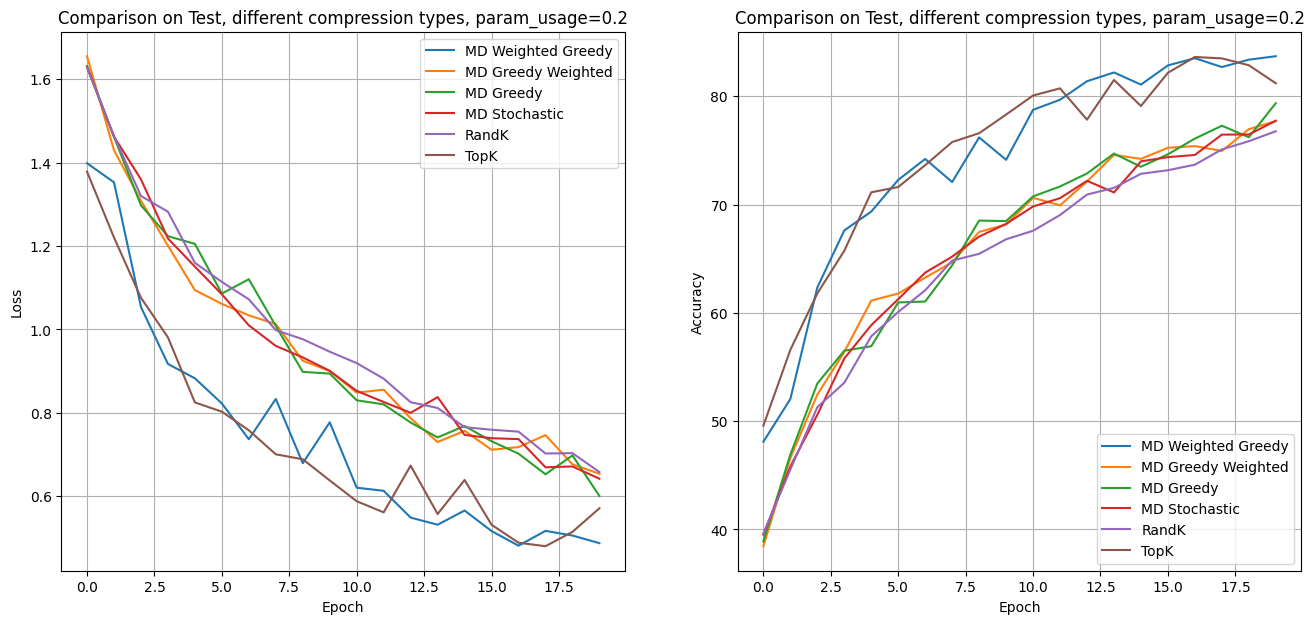

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'MD Stochastic',
    'mirror_descent_weighted_topk': 'MD Weighted Greedy',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Greedy Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

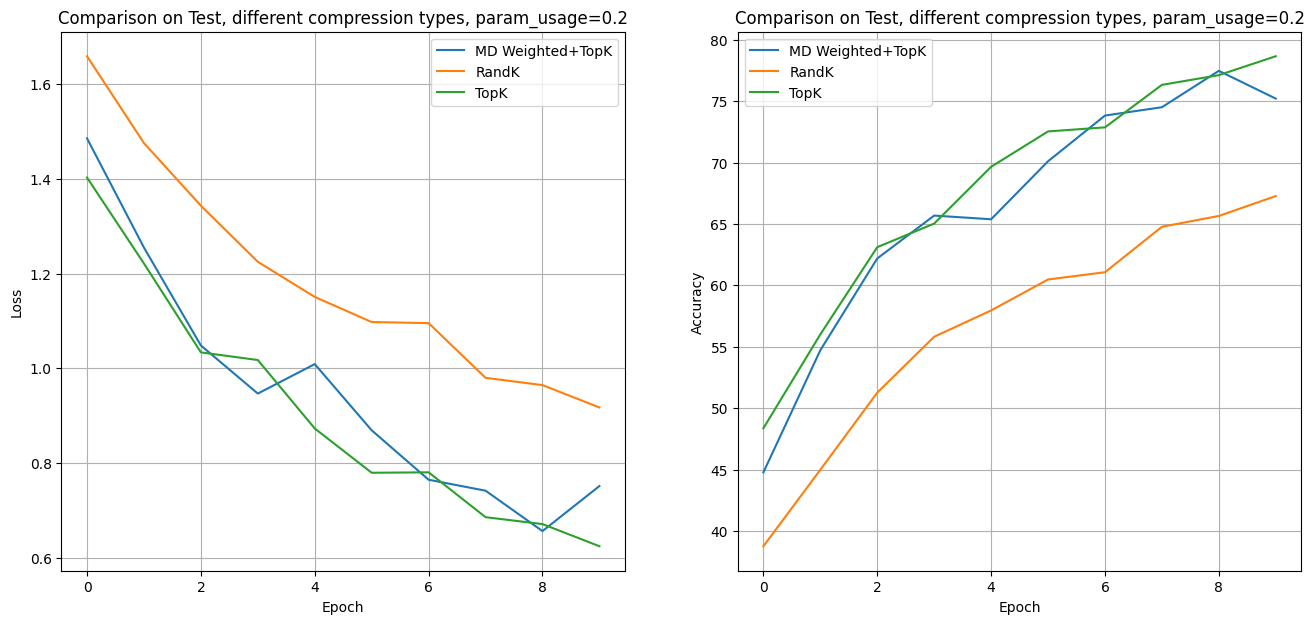

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_weighted_topk': 'MD Weighted+TopK',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

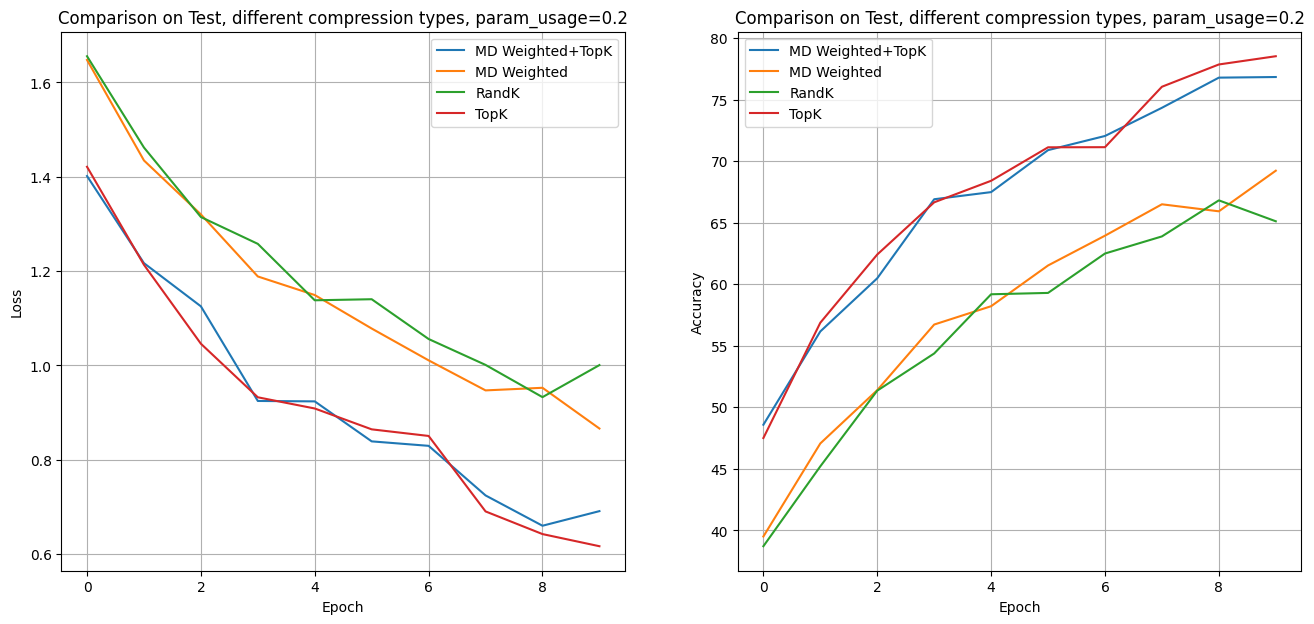

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_weighted_topk': 'MD Weighted+TopK',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

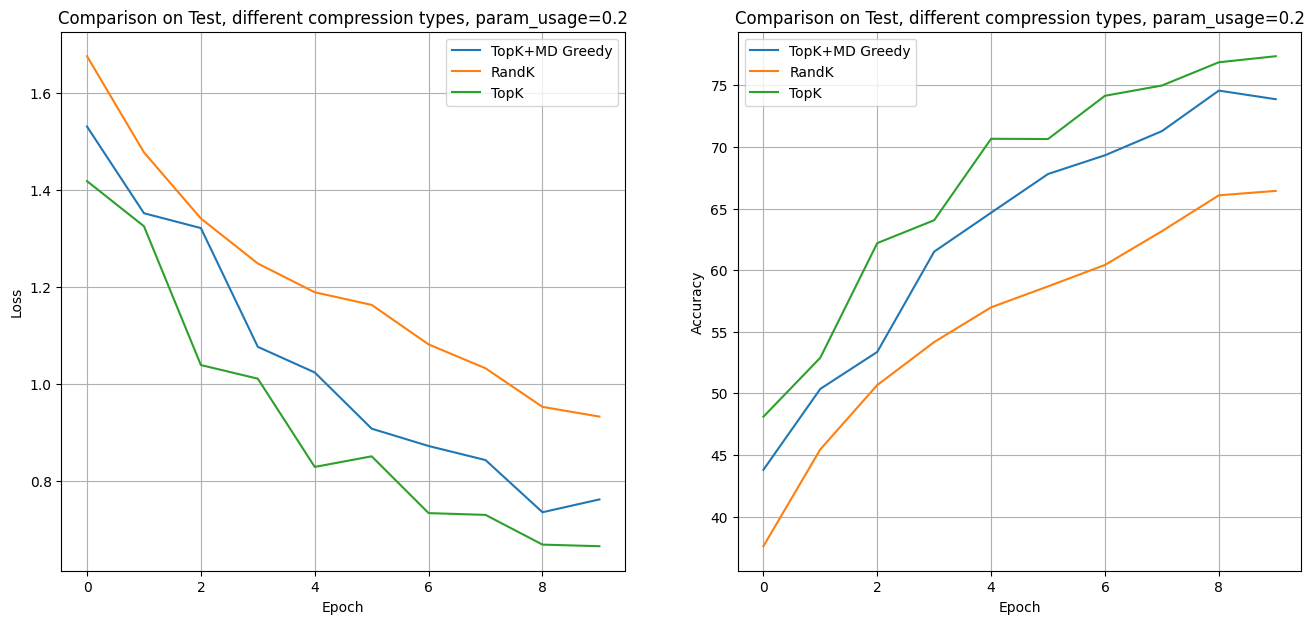

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

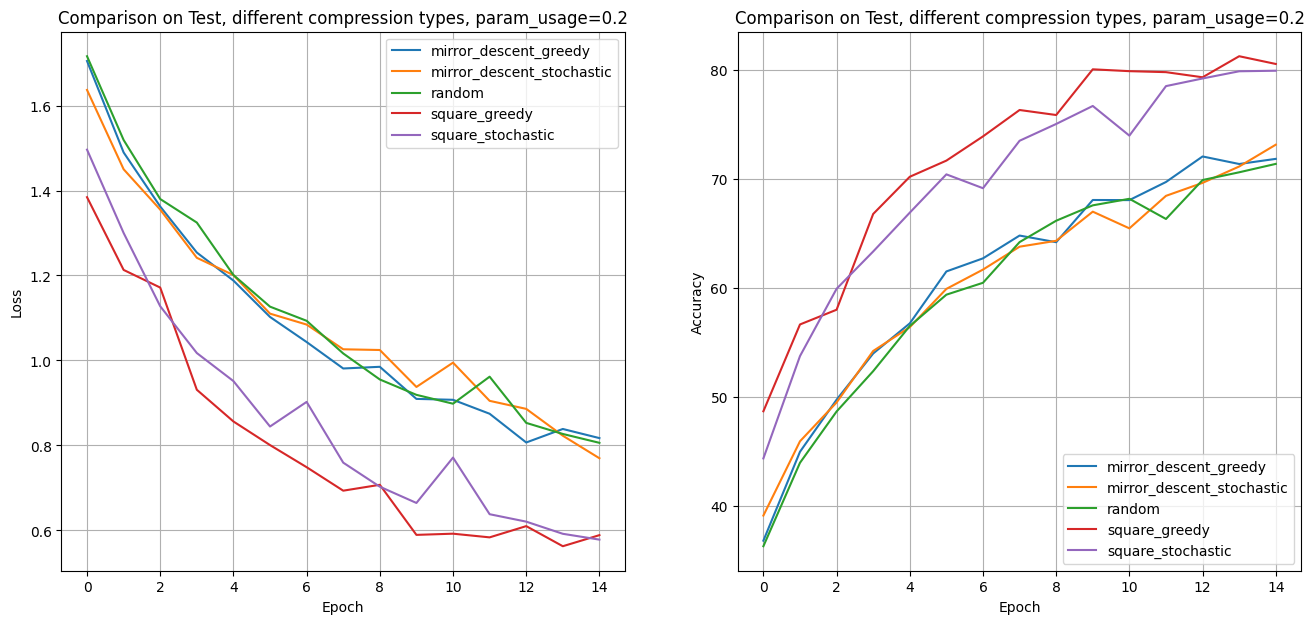

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for compression_type in compression_types:
    axs[0].plot(test_log[compression_type], label=compression_type)
    axs[1].plot(test_acc[compression_type], label=compression_type)

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

Mirror descent with start point g^2

In [27]:
from math import ceil
from tqdm import tqdm, trange

def train(model, optimizer, criterion, train_dataset, val_dataset, num_epochs, compression_type, lr, param_usage=0.2):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    
    if compression_type == 'mirror_descent_stochastic' or compression_type == 'mirror_descent_greedy':
        w = {name: None
            for name, param in model.named_parameters()
        }
    
    for epoch in trange(num_epochs):
        print('\nEpoch: %d' % epoch)
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_dataset):
            inputs, targets = inputs.to(device), targets.to(device)
            if batch_idx == 0 and (compression_type == 'mirror_descent_stochastic' or compression_type == 'mirror_descent_greedy'):
                for name, param in model.named_parameters():
                    if w[name] is None:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        loss.backward()
                        w[name] = param.grad.detach()**2
                    w[name] = mirror_descent(
                        model=model,
                        param_name=name,
                        impact=w[name],
                        lr=lr,
                        eta=2,
                        lambda_value=1,
                        num_steps=100,
                        X_train=inputs,
                        y_train=targets,
                        criterion=criterion
                    )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            if compression_type == 'square_stochastic':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'square_greedy':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.argsort(w, descending=True)[:ceil(param_usage * len(w))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'random':
                for param in model.parameters():
                    w = torch.ones_like(param.grad.flatten())
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_stochastic':
                for name, param in model.named_parameters():
                    indice = torch.multinomial(w[name].flatten(), ceil(param_usage * len(w[name].flatten())))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy':
                for name, param in model.named_parameters():
                    indice = torch.argsort(w[name].flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            else:
                raise ValueError(f"Compression type {compression_type} not supported")
            
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss /= len(train_dataset)
        train_accuracy = 100. * correct / total
        train_log.append(train_loss)
        train_acc_log.append(train_accuracy)
        
        print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)' % (train_loss, train_accuracy, correct, total))
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_dataset:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss /= len(val_dataset)
        val_accuracy = 100. * correct / total
        val_log.append(val_loss)
        val_acc_log.append(val_accuracy)
        
        print('Validation Loss: %.3f | Validation Acc: %.3f%% (%d/%d)' % (val_loss, val_accuracy, correct, total))
    
    return train_log, train_acc_log, val_log, val_acc_log

In [28]:
compression_types_extra = ['mirror_descent_greedy', 'mirror_descent_stochastic']
for compression_type in compression_types_extra:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[compression_type], train_acc[compression_type], test_log[compression_type], test_acc[compression_type] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.927 | Train Acc: 28.090% (14045/50000)


  7%|▋         | 1/15 [01:30<21:00, 90.00s/it]

Validation Loss: 1.632 | Validation Acc: 39.030% (3903/10000)

Epoch: 1
Train Loss: 1.568 | Train Acc: 42.182% (21091/50000)


 13%|█▎        | 2/15 [02:58<19:16, 88.95s/it]

Validation Loss: 1.480 | Validation Acc: 45.730% (4573/10000)

Epoch: 2
Train Loss: 1.405 | Train Acc: 48.848% (24424/50000)


 20%|██        | 3/15 [04:31<18:12, 91.07s/it]

Validation Loss: 1.304 | Validation Acc: 52.090% (5209/10000)

Epoch: 3
Train Loss: 1.294 | Train Acc: 53.144% (26572/50000)


 27%|██▋       | 4/15 [06:03<16:42, 91.18s/it]

Validation Loss: 1.269 | Validation Acc: 54.200% (5420/10000)

Epoch: 4
Train Loss: 1.206 | Train Acc: 56.454% (28227/50000)


 33%|███▎      | 5/15 [07:31<15:01, 90.15s/it]

Validation Loss: 1.240 | Validation Acc: 55.510% (5551/10000)

Epoch: 5
Train Loss: 1.118 | Train Acc: 59.756% (29878/50000)


 40%|████      | 6/15 [08:59<13:24, 89.40s/it]

Validation Loss: 1.110 | Validation Acc: 60.350% (6035/10000)

Epoch: 6
Train Loss: 1.053 | Train Acc: 62.390% (31195/50000)


 47%|████▋     | 7/15 [10:28<11:53, 89.17s/it]

Validation Loss: 1.034 | Validation Acc: 63.110% (6311/10000)

Epoch: 7
Train Loss: 0.993 | Train Acc: 64.522% (32261/50000)


 53%|█████▎    | 8/15 [11:57<10:24, 89.21s/it]

Validation Loss: 0.985 | Validation Acc: 65.190% (6519/10000)

Epoch: 8
Train Loss: 0.944 | Train Acc: 66.478% (33239/50000)


 60%|██████    | 9/15 [13:24<08:51, 88.56s/it]

Validation Loss: 0.917 | Validation Acc: 67.140% (6714/10000)

Epoch: 9
Train Loss: 0.902 | Train Acc: 67.836% (33918/50000)


 67%|██████▋   | 10/15 [14:51<07:20, 88.12s/it]

Validation Loss: 0.934 | Validation Acc: 66.950% (6695/10000)

Epoch: 10
Train Loss: 0.857 | Train Acc: 69.470% (34735/50000)


 73%|███████▎  | 11/15 [16:20<05:52, 88.24s/it]

Validation Loss: 0.908 | Validation Acc: 68.240% (6824/10000)

Epoch: 11
Train Loss: 0.821 | Train Acc: 71.014% (35507/50000)


 80%|████████  | 12/15 [17:48<04:25, 88.40s/it]

Validation Loss: 0.858 | Validation Acc: 70.070% (7007/10000)

Epoch: 12
Train Loss: 0.787 | Train Acc: 72.138% (36069/50000)


 87%|████████▋ | 13/15 [19:21<02:59, 89.61s/it]

Validation Loss: 0.811 | Validation Acc: 71.700% (7170/10000)

Epoch: 13
Train Loss: 0.754 | Train Acc: 73.426% (36713/50000)


 93%|█████████▎| 14/15 [20:48<01:28, 88.89s/it]

Validation Loss: 0.788 | Validation Acc: 72.560% (7256/10000)

Epoch: 14
Train Loss: 0.722 | Train Acc: 74.680% (37340/50000)


100%|██████████| 15/15 [22:15<00:00, 89.01s/it]


Validation Loss: 0.796 | Validation Acc: 72.310% (7231/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.914 | Train Acc: 28.814% (14407/50000)


  7%|▋         | 1/15 [01:35<22:20, 95.75s/it]

Validation Loss: 1.625 | Validation Acc: 40.260% (4026/10000)

Epoch: 1
Train Loss: 1.583 | Train Acc: 41.212% (20606/50000)


 13%|█▎        | 2/15 [03:07<20:11, 93.20s/it]

Validation Loss: 1.455 | Validation Acc: 45.830% (4583/10000)

Epoch: 2
Train Loss: 1.441 | Train Acc: 46.958% (23479/50000)


 20%|██        | 3/15 [04:40<18:36, 93.04s/it]

Validation Loss: 1.366 | Validation Acc: 49.490% (4949/10000)

Epoch: 3
Train Loss: 1.329 | Train Acc: 51.664% (25832/50000)


 27%|██▋       | 4/15 [06:14<17:08, 93.48s/it]

Validation Loss: 1.258 | Validation Acc: 54.130% (5413/10000)

Epoch: 4
Train Loss: 1.238 | Train Acc: 55.210% (27605/50000)


 33%|███▎      | 5/15 [07:46<15:28, 92.89s/it]

Validation Loss: 1.193 | Validation Acc: 56.960% (5696/10000)

Epoch: 5
Train Loss: 1.155 | Train Acc: 58.516% (29258/50000)


 40%|████      | 6/15 [09:17<13:53, 92.57s/it]

Validation Loss: 1.142 | Validation Acc: 59.000% (5900/10000)

Epoch: 6
Train Loss: 1.090 | Train Acc: 60.444% (30222/50000)


 47%|████▋     | 7/15 [10:50<12:19, 92.43s/it]

Validation Loss: 1.076 | Validation Acc: 61.570% (6157/10000)

Epoch: 7
Train Loss: 1.033 | Train Acc: 62.956% (31478/50000)


 53%|█████▎    | 8/15 [12:21<10:44, 92.14s/it]

Validation Loss: 1.025 | Validation Acc: 63.580% (6358/10000)

Epoch: 8
Train Loss: 0.981 | Train Acc: 64.790% (32395/50000)


 60%|██████    | 9/15 [13:53<09:11, 91.96s/it]

Validation Loss: 0.993 | Validation Acc: 64.870% (6487/10000)

Epoch: 9
Train Loss: 0.940 | Train Acc: 66.436% (33218/50000)


 67%|██████▋   | 10/15 [15:23<07:37, 91.44s/it]

Validation Loss: 0.960 | Validation Acc: 66.270% (6627/10000)

Epoch: 10
Train Loss: 0.894 | Train Acc: 68.448% (34224/50000)


 73%|███████▎  | 11/15 [16:52<06:02, 90.73s/it]

Validation Loss: 0.955 | Validation Acc: 66.990% (6699/10000)

Epoch: 11
Train Loss: 0.862 | Train Acc: 69.276% (34638/50000)


 80%|████████  | 12/15 [18:22<04:31, 90.41s/it]

Validation Loss: 0.871 | Validation Acc: 68.980% (6898/10000)

Epoch: 12
Train Loss: 0.823 | Train Acc: 70.662% (35331/50000)


 87%|████████▋ | 13/15 [19:51<02:59, 89.94s/it]

Validation Loss: 0.903 | Validation Acc: 68.530% (6853/10000)

Epoch: 13
Train Loss: 0.790 | Train Acc: 71.960% (35980/50000)


 93%|█████████▎| 14/15 [21:20<01:29, 89.75s/it]

Validation Loss: 0.851 | Validation Acc: 70.420% (7042/10000)

Epoch: 14
Train Loss: 0.766 | Train Acc: 73.002% (36501/50000)


100%|██████████| 15/15 [22:50<00:00, 91.35s/it]

Validation Loss: 0.797 | Validation Acc: 72.440% (7244/10000)


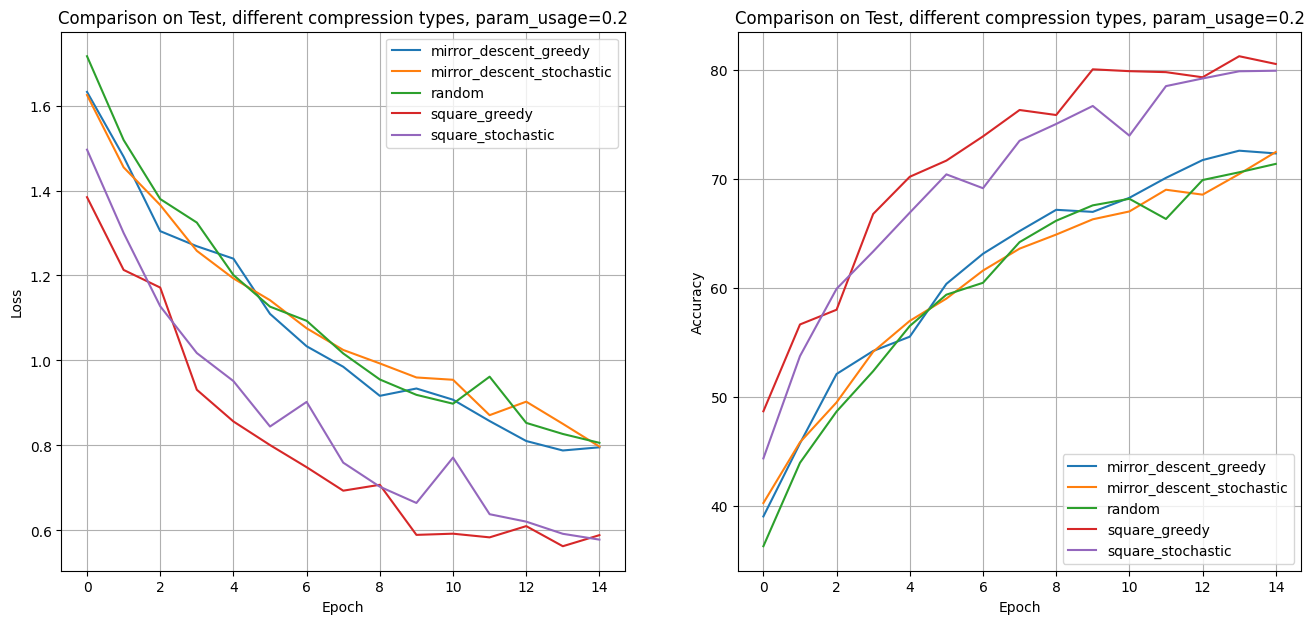

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=compression_type)
    axs[1].plot(test_acc[compression_type], label=compression_type)

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()